# NanoPyx "Codeless" Jupyter Notebook

### This notebook allows you to generate align a timelapse

**Channel Registration** Romain F Laine et al 2019 J. Phys. D: Appl. Phys. 52 163001

## Notebook setup cell
Run the following cell to install nanopyx

In [ ]:
!pip install git+https://github.com/HenriquesLab/NanoPyx.git

Now, import all necessary python libraries

In [2]:
import io
import os
import skimage
import numpy as np
import tifffile as tiff
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib import pyplot as plt

from nanopyx.methods import channel_registration
from nanopyx.core.utils.easy_gui import EasyGui
from nanopyx.core.utils.easy_gui import view_image_stack, view_curtain_stack, view_image

## Select which image to load

Label(value='Select data to use:', layout=Layout(width='50%'), style=LabelStyle(description_width='initial'))

FileChooser(path='/Users/bsaraiva/Code/NanoPyx/notebooks', filename='', title='', show_hidden=False, select_de…

Button(description='Load data', layout=Layout(width='50%'), style=ButtonStyle())

interactive(children=(IntSlider(value=0, description='dim0', max=1), Output()), _dom_classes=('widget-interact…

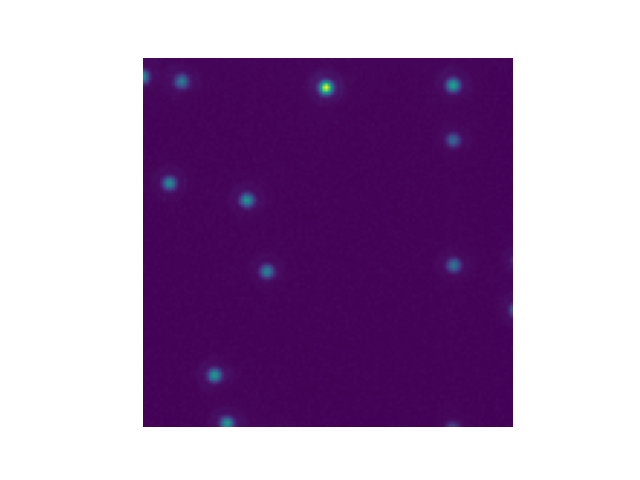

In [ ]:
%matplotlib widget
# Create a GUI
gui_data = EasyGui("Data Loader")

def on_button_load_data_clicked(b):
    clear_output()
    gui_data.show()
    global dataset_original
    # disable button
    gui_data["load_data"].disabled = True
    gui_data["load_data"].description = "Loading..."
    dataset_original = tiff.imread(gui_data["upload"].selected)
    gui_data["load_data"].disabled = False
    gui_data["load_data"].description = "Load data"
    view_image_stack(dataset_original)

gui_data.add_label("Select data to use:")
gui_data.add_file_upload("upload")
gui_data.add_button("load_data", description="Load data")
gui_data["load_data"].on_click(on_button_load_data_clicked)
gui_data.show()

## Now let's perform the registration

Label(value='Channel Registration parameters:', layout=Layout(width='50%'), style=LabelStyle(description_width…

IntSlider(value=0, description='Reference channel', layout=Layout(width='50%'), max=1, style=SliderStyle(descr…

IntSlider(value=10, description='Max expected drift', layout=Layout(width='50%'), max=1000, style=SliderStyle(…

IntSlider(value=5, description='Blocks per axis', layout=Layout(width='50%'), max=10, min=1, style=SliderStyle…

FloatSlider(value=0.5, description='Minimum similarity', layout=Layout(width='50%'), max=1.0, style=SliderStyl…

Button(description='Register', layout=Layout(width='50%'), style=ButtonStyle())

estimate_channel_registration took 0.093 seconds


interactive(children=(IntSlider(value=0, description='dim0', max=1), Output()), _dom_classes=('widget-interact…

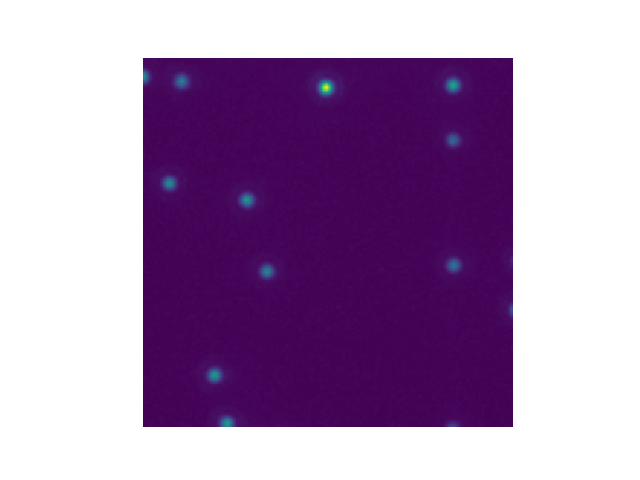

In [ ]:
gui_reg = EasyGui("Channel Registration")

def on_button_register(b):
    clear_output()
    gui_reg.show()
    ref_channel = gui_reg["ref"].value
    max_shift = gui_reg["max"].value
    n_blocks = gui_reg["blocks"].value
    min_sim = gui_reg["min_sim"].value
    global dataset_registered
    gui_reg["register"].disabled = True
    gui_reg["register"].description = "Aligning..."
    dataset_registered = channel_registration.estimate_channel_registration(dataset_original,
                                                                            ref_channel,
                                                                            max_shift,
                                                                            n_blocks,
                                                                            min_sim,
                                                                            save_translation_masks=False,
                                                                            save_ccms=False,
                                                                            apply=True)
    gui_reg["register"].disabled = False
    gui_reg["register"].description = "Align"
    view_image_stack(dataset_registered)

gui_reg.add_label("Channel Registration parameters:")
gui_reg.add_int_slider("ref", description="Reference channel", min=0, max=dataset_original.shape[0]-1, value=0)
gui_reg.add_int_slider("max", description="Max expected drift", min=0, max=1000, value=10)
gui_reg.add_int_slider("blocks", description="Blocks per axis", min=1, max=10, value=5)
gui_reg.add_float_slider("min_sim", description="Minimum similarity", min=0, max=1, value=0.5, step=0.1)
gui_reg.add_button("register", description="Register")
gui_reg["register"].on_click(on_button_register)
gui_reg.show()